# Compression of DL models

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


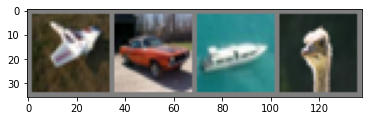

plane car   ship  bird 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [6]:
net = net.to(device)

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [8]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}', end=" ")
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.193 [1,  4000] loss: 1.834 [1,  6000] loss: 1.654 [1,  8000] loss: 1.545 [1, 10000] loss: 1.486 [1, 12000] loss: 1.428 [2,  2000] loss: 1.366 [2,  4000] loss: 1.342 [2,  6000] loss: 1.303 [2,  8000] loss: 1.282 [2, 10000] loss: 1.281 [2, 12000] loss: 1.248 [3,  2000] loss: 1.181 [3,  4000] loss: 1.209 [3,  6000] loss: 1.175 [3,  8000] loss: 1.150 [3, 10000] loss: 1.160 [3, 12000] loss: 1.151 [4,  2000] loss: 1.068 [4,  4000] loss: 1.100 [4,  6000] loss: 1.084 [4,  8000] loss: 1.079 [4, 10000] loss: 1.086 [4, 12000] loss: 1.074 [5,  2000] loss: 0.990 [5,  4000] loss: 1.037 [5,  6000] loss: 0.986 [5,  8000] loss: 1.008 [5, 10000] loss: 1.009 [5, 12000] loss: 1.029 [6,  2000] loss: 0.918 [6,  4000] loss: 0.929 [6,  6000] loss: 0.964 [6,  8000] loss: 0.975 [6, 10000] loss: 0.976 [6, 12000] loss: 0.964 [7,  2000] loss: 0.853 [7,  4000] loss: 0.908 [7,  6000] loss: 0.919 [7,  8000] loss: 0.917 [7, 10000] loss: 0.937 [7, 12000] loss: 0.931 [8,  2000] loss: 0.811 [8,  4000] 

In [9]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 64 %


In [10]:
im = images[0,:,:,:].reshape(1,3,32,32).to(device)

In [11]:
%%timeit -n 10 -r 10
with torch.no_grad():
    pred = net(im)

The slowest run took 4.92 times longer than the fastest. This could mean that an intermediate result is being cached.
1.05 ms ± 401 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


### Pruning

In [12]:
import torch.nn.utils.prune as prune

In [13]:
net = Net()
net = net.to(device)

parameters_to_prune = (
    (net.conv1, 'weight'),
    (net.conv2, 'weight'),
    (net.fc1, 'weight'),
    (net.fc2, 'weight'),
    (net.fc3, 'weight'),
)

prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}', end=" ")
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.277 [1,  4000] loss: 1.948 [1,  6000] loss: 1.692 [1,  8000] loss: 1.620 [1, 10000] loss: 1.524 [1, 12000] loss: 1.490 [2,  2000] loss: 1.402 [2,  4000] loss: 1.370 [2,  6000] loss: 1.341 [2,  8000] loss: 1.317 [2, 10000] loss: 1.290 [2, 12000] loss: 1.264 [3,  2000] loss: 1.205 [3,  4000] loss: 1.197 [3,  6000] loss: 1.181 [3,  8000] loss: 1.176 [3, 10000] loss: 1.171 [3, 12000] loss: 1.168 [4,  2000] loss: 1.111 [4,  4000] loss: 1.085 [4,  6000] loss: 1.090 [4,  8000] loss: 1.092 [4, 10000] loss: 1.101 [4, 12000] loss: 1.096 [5,  2000] loss: 1.032 [5,  4000] loss: 1.029 [5,  6000] loss: 1.033 [5,  8000] loss: 1.045 [5, 10000] loss: 1.023 [5, 12000] loss: 1.052 [6,  2000] loss: 0.947 [6,  4000] loss: 0.966 [6,  6000] loss: 0.998 [6,  8000] loss: 0.991 [6, 10000] loss: 0.997 [6, 12000] loss: 0.986 [7,  2000] loss: 0.889 [7,  4000] loss: 0.926 [7,  6000] loss: 0.926 [7,  8000] loss: 0.957 [7, 10000] loss: 0.961 [7, 12000] loss: 0.956 [8,  2000] loss: 0.849 [8,  4000] 

In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 61 %


In [15]:
%%timeit -n 10 -r 10
with torch.no_grad():
    pred = net(im)

The slowest run took 4.84 times longer than the fastest. This could mean that an intermediate result is being cached.
1.42 ms ± 673 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


### Quantization 

In [16]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}', end=" ")
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.190 [1,  4000] loss: 1.838 [1,  6000] loss: 1.679 [1,  8000] loss: 1.565 [1, 10000] loss: 1.510 [1, 12000] loss: 1.462 [2,  2000] loss: 1.392 [2,  4000] loss: 1.365 [2,  6000] loss: 1.309 [2,  8000] loss: 1.321 [2, 10000] loss: 1.297 [2, 12000] loss: 1.255 [3,  2000] loss: 1.187 [3,  4000] loss: 1.187 [3,  6000] loss: 1.192 [3,  8000] loss: 1.191 [3, 10000] loss: 1.194 [3, 12000] loss: 1.181 [4,  2000] loss: 1.083 [4,  4000] loss: 1.115 [4,  6000] loss: 1.101 [4,  8000] loss: 1.103 [4, 10000] loss: 1.100 [4, 12000] loss: 1.098 [5,  2000] loss: 1.020 [5,  4000] loss: 1.035 [5,  6000] loss: 1.036 [5,  8000] loss: 1.038 [5, 10000] loss: 1.028 [5, 12000] loss: 1.052 [6,  2000] loss: 0.938 [6,  4000] loss: 0.963 [6,  6000] loss: 0.987 [6,  8000] loss: 0.986 [6, 10000] loss: 0.998 [6, 12000] loss: 1.017 [7,  2000] loss: 0.919 [7,  4000] loss: 0.907 [7,  6000] loss: 0.931 [7,  8000] loss: 0.921 [7, 10000] loss: 0.966 [7, 12000] loss: 0.941 [8,  2000] loss: 0.847 [8,  4000] 

In [17]:
# insert observers
torch.quantization.prepare(net, inplace=True)

# Calibrate the model and collect statistics

# convert to quantized version
torch.quantization.convert(net, inplace=True)

/home/german/anaconda3/envs/compression/lib/python3.9/site-packages/torch/ao/quantization/quantize.py:310: UserWarning: None of the submodule got qconfig applied. Make sure you passed correct configuration through `qconfig_dict` or by assigning the `.qconfig` attribute directly on submodules
  warnings.warn("None of the submodule got qconfig applied. Make sure you "


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [18]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 60 %


In [19]:
%%timeit -n 10 -r 10
with torch.no_grad():
    pred = net(im)

550 µs ± 37.4 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [20]:
Net()

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [21]:
! pip install -q tensorflow-model-optimization